/tmp/ipykernel_2829168/1688639035.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment['Time'] = np.arange(len(segment))  # 从0开始递增
/tmp/ipykernel_2829168/1688639035.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment['SequenceID'] = f"{group['UniqueWormID'].iloc[0]}_segment_{i + 1}"
/tmp/ipykernel_2829168/1688639035.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196617 entries, 0 to 196616
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Centroid_X         196617 non-null  int64  
 1   Centroid_Y         196617 non-null  int64  
 2   KeypointA_X        196617 non-null  int64  
 3   KeypointA_Y        196617 non-null  int64  
 4   KeypointB_X        196617 non-null  int64  
 5   KeypointB_Y        196617 non-null  int64  
 6   Centroid_Velocity  196617 non-null  float64
 7   UniqueWormID       196617 non-null  int64  
 8   Time               196617 non-null  int64  
 9   delta_X            196616 non-null  float64
 10  delta_Y            196616 non-null  float64
 11  delta_velocity     196616 non-null  float64
 12  direction          196616 non-null  float64
 13  SequenceID         196617 non-null  object 
dtypes: float64(5), int64(8), object(1)
memory usage: 21.0+ MB
None
SequenceID 10_segment_1: Found discon

/tmp/ipykernel_2829168/1688639035.py:294: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # 留出右侧空间给颜色条


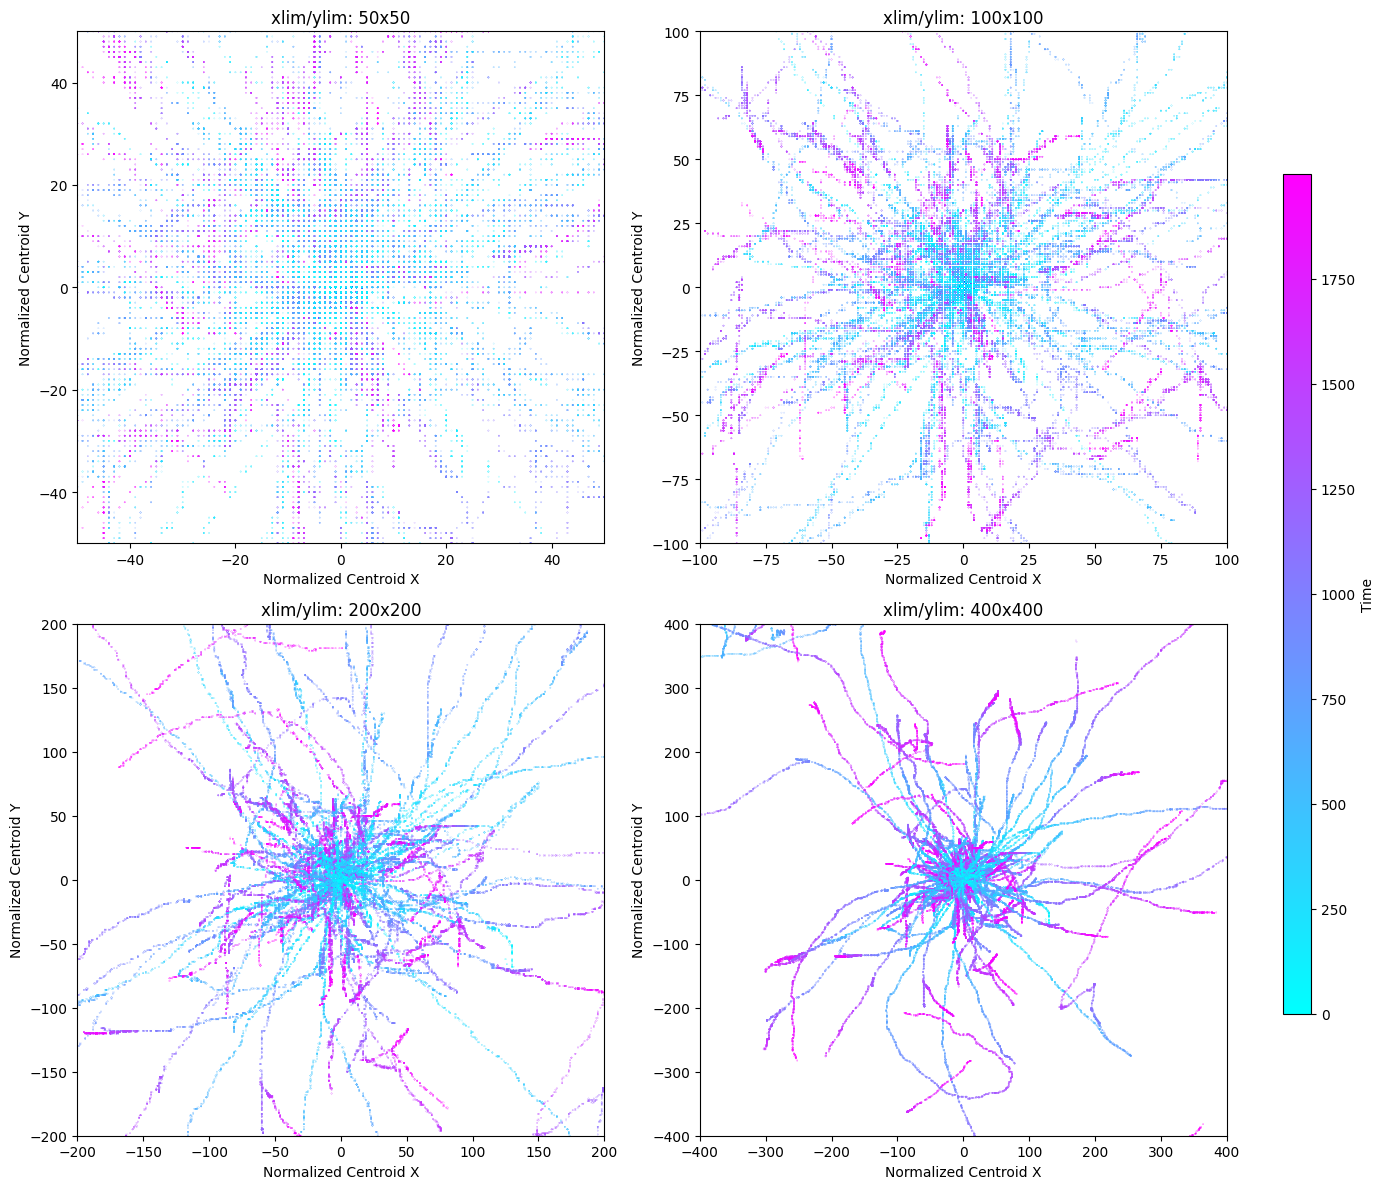

In [1]:

import pandas as pd
import glob
import numpy as np
import os
# 1. 读取所有CSV文件
file_paths = glob.glob("dataset/*.csv")
all_data = []

# 用于为每个WormID分配唯一标识符
unique_worm_id_counter = {}

for file in file_paths:
    # 读取单个CSV文件
    df = pd.read_csv(file)
    
    # 添加一个新的列来标识数据来源，方便后续追踪
    df['CSV_source'] = file
    
    # 为每个WormID生成唯一的WormID
    df['UniqueWormID'] = df['WormID'].apply(lambda x: unique_worm_id_counter.setdefault(x, len(unique_worm_id_counter) + 1))
    
    # 将每个CSV文件的data添加到all_data列表中
    all_data.append(df)

# 2. 合并所有CSV文件的数据
merged_data = pd.concat(all_data, ignore_index=True)

# 3. 对每只线虫的时间进行标准化
def standardize_time_for_worm(group):
    # 获取每只线虫的第一次出现的时间
    first_frame = group['Frame'].min()
    # 重新设定每只线虫的时间为从0开始
    group['Time'] = group['Frame'] - first_frame
    return group

# 按UniqueWormID分组并进行时间标准化
merged_data = merged_data.groupby('UniqueWormID').apply(standardize_time_for_worm)

# 填充缺失值
merged_data.fillna(method='ffill', inplace=True)  # 使用前一个有效数据填充
# 通过描述性统计查看数据范围
# print(merged_data.describe())
merged_data['delta_X'] = merged_data['Centroid_X'].diff()  # X轴变化
merged_data['delta_Y'] = merged_data['Centroid_Y'].diff()  # Y轴变化
merged_data['delta_velocity'] = merged_data['Centroid_Velocity'].diff()  # 速度变化
merged_data['direction'] = np.arctan2(merged_data['delta_Y'], merged_data['delta_X'])  # 计算角度（方向）

merged_data = merged_data.drop(['WormID','CSV_source','Frame'],axis=1)
merged_data = merged_data.drop(['Centroid_Acceleration'],axis=1)

# 2. 丢弃 Time 最大值小于 100 的线虫
max_times = merged_data.groupby('UniqueWormID')['Time'].max()
valid_worms = max_times[max_times >= 100].index
merged_data = merged_data[merged_data['UniqueWormID'].isin(valid_worms)]

# 3. 将轨迹切割成相同长度的段
def cut_trajectory_into_segments(group, segment_length=2000):
    n_points = len(group)
    n_segments = (n_points + segment_length - 1) // segment_length  # 向上取整

    # 如果轨迹不足 segment_length，将数据填充
    if n_points < segment_length:
        padding = segment_length - n_points
        group = pd.concat([group, group.tail(padding)], ignore_index=True)
        n_segments = 1

    segments = []
    for i in range(n_segments):
        start_idx = i * segment_length
        end_idx = min((i + 1) * segment_length, len(group))
        segment = group.iloc[start_idx:end_idx]

        # 重新配置时间
        segment['Time'] = np.arange(len(segment))  # 从0开始递增

        # 添加 SequenceID 列
        segment['SequenceID'] = f"{group['UniqueWormID'].iloc[0]}_segment_{i + 1}"
        
        segments.append(segment)

    return segments

# 4. 对每个线虫的轨迹进行切割并重新配置时间
segmented_data = []

# 遍历每个 UniqueWormID 对应的轨迹
for worm_id, group in merged_data.groupby('UniqueWormID'):
    segments = cut_trajectory_into_segments(group)
    
    # 将所有段合并到 segmented_data 列表中
    for segment in segments:
        segmented_data.append(segment)

# 将所有段合并为一个 DataFrame
final_data = pd.concat(segmented_data, ignore_index=True)

# 5. 保存总的文件
# final_data.to_csv("segmented_worm_data.csv", index=False)

# 6. 检查保存结果
print(final_data.info())
##################################3


# 读取处理后的数据
# final_data = pd.read_csv('segmented_worm_data.csv')

# 检查连续性并分割不连续的序列
def split_discontinuous_sequences(data, segment_length=2000, min_length=100, delta_threshold=100):
    new_segments = []  # 存储修复后的新序列

    for sequence_id, group in data.groupby('SequenceID'):
        group = group.reset_index(drop=True)  # 重置索引以确保连续性
        segments_to_process = [group]  # 初始化需要处理的段

        while segments_to_process:
            current_segment = segments_to_process.pop(0)

            # 计算 delta_X 和 delta_Y
            current_segment['delta_X'] = current_segment['Centroid_X'].diff()
            current_segment['delta_Y'] = current_segment['Centroid_Y'].diff()

            # 找出第一个不连续点的索引
            discontinuity = current_segment[
                (current_segment['delta_X'].abs() > delta_threshold) |
                (current_segment['delta_Y'].abs() > delta_threshold)
            ]

            if not discontinuity.empty:
                first_discontinuity_idx = discontinuity.index[0]
                print(f"SequenceID {sequence_id}: Found discontinuity at index {first_discontinuity_idx}")

                # 分割为两部分
                before_split = current_segment.iloc[:first_discontinuity_idx].copy()
                after_split = current_segment.iloc[first_discontinuity_idx:].copy()

                # 如果前半部分长度大于等于 min_length，保留
                if len(before_split) >= min_length:
                    # 填充前半部分到 segment_length
                    if len(before_split) < segment_length:
                        padding = segment_length - len(before_split)
                        padding_df = pd.DataFrame(
                            np.nan,
                            columns=before_split.columns,
                            index=range(padding)
                        )
                        before_split = pd.concat([before_split, padding_df], ignore_index=True)

                    # 重新配置时间和生成新的 SequenceID
                    before_split['Time'] = np.arange(len(before_split))
                    before_split['SequenceID'] = f"{sequence_id}_split_{len(new_segments) + 1}"
                    new_segments.append(before_split)

                else:
                    print(f"SequenceID {sequence_id}: Segment before discontinuity discarded due to insufficient length ({len(before_split)})")

                # 将后半部分加入待处理列表
                segments_to_process.insert(0, after_split)
            else:
                # 没有不连续点，直接处理当前段
                if len(current_segment) >= min_length:
                    # 填充当前段到 segment_length
                    if len(current_segment) < segment_length:
                        padding = segment_length - len(current_segment)
                        padding_df = pd.DataFrame(
                            np.nan,
                            columns=current_segment.columns,
                            index=range(padding)
                        )
                        current_segment = pd.concat([current_segment, padding_df], ignore_index=True)

                    # 重新配置时间和生成新的 SequenceID
                    current_segment['Time'] = np.arange(len(current_segment))
                    current_segment['SequenceID'] = f"{sequence_id}_split_{len(new_segments) + 1}"
                    new_segments.append(current_segment)
                else:
                    print(f"SequenceID {sequence_id}: Segment discarded due to insufficient length ({len(current_segment)})")

        # 处理完所有需要分割的段后，继续下一个 SequenceID

    # 将所有修复后的段合并为一个 DataFrame
    return pd.concat(new_segments, ignore_index=True)

# 执行修复
segment_length = 2000  # 设定填充的目标长度
min_length = 100  # 设定最小保留长度
delta_threshold = 100  # 设定 delta 的阈值
final_fixed_data = split_discontinuous_sequences(final_data, segment_length, min_length, delta_threshold)

# 重新计算 delta_X 和 delta_Y
final_fixed_data = final_fixed_data.sort_values(by=['SequenceID', 'Time']).reset_index(drop=True)
final_fixed_data[['delta_X', 'delta_Y']] = final_fixed_data.groupby('SequenceID')[['Centroid_X', 'Centroid_Y']].diff()

# 保存修复后的数据
# final_fixed_data.to_csv('fixed_segmented_worm_data.csv', index=False)

# 检查修复后的结果
print(final_fixed_data.info())



# # ################

# # 5. 可视化 - 绘制整体移动的轨迹
# plt.figure(figsize=(10, 8))

# # 遍历每个轨迹段，并绘制
# for sequence_id, group in final_data.groupby('SequenceID'):
#     x = group['Centroid_X']
#     y = group['Centroid_Y']
#     time = group['Time']  # 时间用于映射颜色
    
#     # 归一化时间
#     norm = Normalize(vmin=final_data['Time'].min(), vmax=final_data['Time'].max())  # 确保所有轨迹统一时间范围
#     cmap = cm.cold  # 选择颜色映射（viridis 可以根据需要替换）
    
#     # 绘制轨迹，时间对应的颜色
#     scatter = plt.scatter(x, y, c=time, cmap=cmap, norm=norm, s=0.01
#                           )

# # 添加颜色条，绑定到 scatter 的 mappable 对象
# cbar = plt.colorbar(scatter)
# cbar.set_label('Time')


# # 添加标题和标签
# plt.title("Normalized Worm Trajectories Colored by Time (Trajectory Moved to Origin)")
# plt.xlabel("Normalized Centroid X")
# plt.ylabel("Normalized Centroid Y")

# # 显示图形
# plt.show()

# 假设 final_data 是你处理后的数据
# final_data = pd.read_csv('fixed_segmented_worm_data.csv')

# 1. 对每个 SequenceID 下的轨迹进行整体移动
def normalize_start_position(group):
    # 获取每个轨迹段的起始坐标（第一个时间点的坐标）
    start_x = group['Centroid_X'].iloc[0]
    start_y = group['Centroid_Y'].iloc[0]
    
    # 将每个轨迹的所有坐标移动到以 (0, 0) 为起点
    group['Centroid_X'] = group['Centroid_X'] - start_x
    group['Centroid_Y'] = group['Centroid_Y'] - start_y
    group['KeypointA_X'] = group['KeypointA_X'] - start_x
    group['KeypointA_Y'] = group['KeypointA_Y'] - start_y
    group['KeypointB_X'] = group['KeypointB_X'] - start_x
    group['KeypointB_Y'] = group['KeypointB_Y'] - start_y
    
    return group

# 对每个 SequenceID 进行整体移动
final_data = final_data.groupby('SequenceID').apply(normalize_start_position)

# 4. 保存结果到文件
final_data.to_csv('normalized_worm_data.csv', index=False)
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize

# 定义子图布局和坐标范围
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
limits = [(50, 50), (100, 100), (200, 200), (400, 400)]  # 不同的坐标范围
titles = ["xlim/ylim: 50x50", "xlim/ylim: 100x100", "xlim/ylim: 200x200", "xlim/ylim: 400x400"]

# 归一化时间，用于颜色映射
norm = Normalize(vmin=final_data['Time'].min(), vmax=final_data['Time'].max())
cmap = cm.cool  # 选择颜色映射

# 遍历每个范围，绘制子图
for ax, limit, title in zip(axes.flatten(), limits, titles):
    for sequence_id, group in final_data.groupby('SequenceID'):
        x = group['Centroid_X']
        y = group['Centroid_Y']
        time = group['Time']
        
        # 绘制轨迹
        scatter = ax.scatter(x, y, c=time, cmap=cmap, norm=norm, s=0.01)
    
    # 设置坐标轴范围和标题
    ax.set_xlim(-limit[0], limit[0])
    ax.set_ylim(-limit[1], limit[1])
    ax.set_title(title)
    ax.set_xlabel("Normalized Centroid X")
    ax.set_ylabel("Normalized Centroid Y")

# 添加全局颜色条
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height] 定义颜色条的位置
cbar = fig.colorbar(scatter, cax=cbar_ax)
cbar.set_label('Time')

# 调整布局
plt.tight_layout(rect=[0, 0, 0.9, 1])  # 留出右侧空间给颜色条
plt.show()


In [ ]:
# 筛选 X 和 Y 坐标均大于 1000 的点
filtered_points = final_data[(final_data['Centroid_X'] > 1000) | (final_data['Centroid_Y'] > 1000)]

# 打印结果
print(filtered_points)



        Centroid_X  Centroid_Y  KeypointA_X  KeypointA_Y  KeypointB_X  \
97102       1003.0       284.0       1049.0        288.0        962.0   
97103       1003.0       284.0       1049.0        288.0        962.0   
97104       1003.0       284.0       1044.0        292.0        962.0   
97105       1003.0       284.0       1044.0        292.0        962.0   
97106       1003.0       284.0       1044.0        290.0        962.0   
...            ...         ...          ...          ...          ...   
185462      1001.0      -745.0        970.0       -705.0       1035.0   
185467      1002.0      -744.0        972.0       -703.0       1031.0   
185468      1002.0      -744.0        972.0       -703.0       1031.0   
185469      1001.0      -743.0        972.0       -702.0       1031.0   
185470      1001.0      -743.0        972.0       -703.0       1031.0   

        KeypointB_Y  Centroid_Velocity  UniqueWormID  Time  delta_X  delta_Y  \
97102         284.0          91.073597     